# Weights

# Setup
* Note tensorflow 2.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import keract
from keract import get_activations
from keract import display_activations
from keract import display_heatmaps

%load_ext tensorboard

In [2]:
tf.__version__

'2.1.0'

# Data

## Load

In [3]:
mnist = keras.datasets.mnist.load_data()

In [4]:
(X_train, y_train), (X_test, y_test) = mnist

In [5]:
print(f'Training Images {X_train.shape}, Labels {y_train.shape}')
print(f'Testing  Images {X_test.shape}, Labels {y_test.shape}')

Training Images (60000, 28, 28), Labels (60000,)
Testing  Images (10000, 28, 28), Labels (10000,)


## Shape

In [6]:
X_train = X_train.reshape(60000, 28, 28, 1).astype('float32')
X_test  = X_test.reshape(10000, 28, 28, 1).astype('float32')

print(f'Training Images {X_train.shape}, Labels {y_train.shape}')
print(f'Testing  Images {X_test.shape}, Labels {y_test.shape}')

Training Images (60000, 28, 28, 1), Labels (60000,)
Testing  Images (10000, 28, 28, 1), Labels (10000,)


In [7]:
X_train /= 255
X_test  /= 255

## EDA

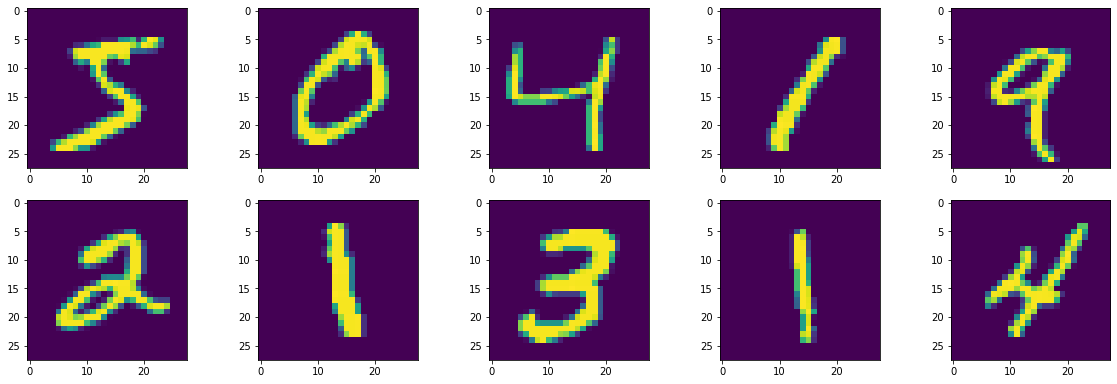

In [8]:
plt.figure(figsize=(20,10))
cols = 5
for i, image in enumerate(X_train[0:10, :]):
    plt.subplot(10 / cols + 1, cols, i + 1)
    plt.imshow(image.squeeze())

# Model

In [9]:
input_shape = (28, 28, 1)

In [10]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(12, kernel_size=(5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 12)          1812      
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               76900     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,878
Trainable params: 79,878
Non-trainable params: 0
____________________________________________________

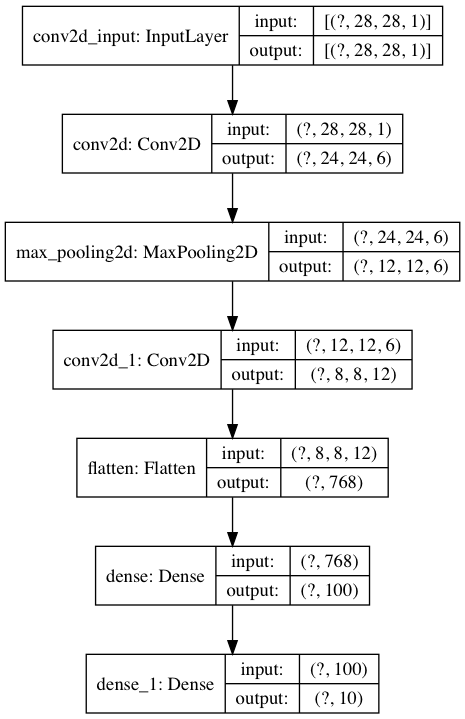

In [31]:
plot_model(model, show_shapes=True)

# TensorBoard

In [13]:
!rm -fr ./tensorlogs/

In [34]:
%tensorboard --logdir tensorlogs/fit

Reusing TensorBoard on port 6006 (pid 90445), started 9 days, 15:47:02 ago. (Use '!kill 90445' to kill it.)

# Training

In [15]:
epochs = 20
batch_size = 64

In [16]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [17]:
logging_dir = './tensorlogs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logging_dir, histogram_freq=1)

In [18]:
history = model.fit(X_train, y_train, 
                    validation_split=0.1, 
                    epochs=epochs, batch_size=batch_size, verbose=0,
                    callbacks=[tensorboard_callback])

# Learning Plots

In [19]:
def plot_performance(history, color='b'):
    fig, ax = plt.subplots(figsize=(12,8))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

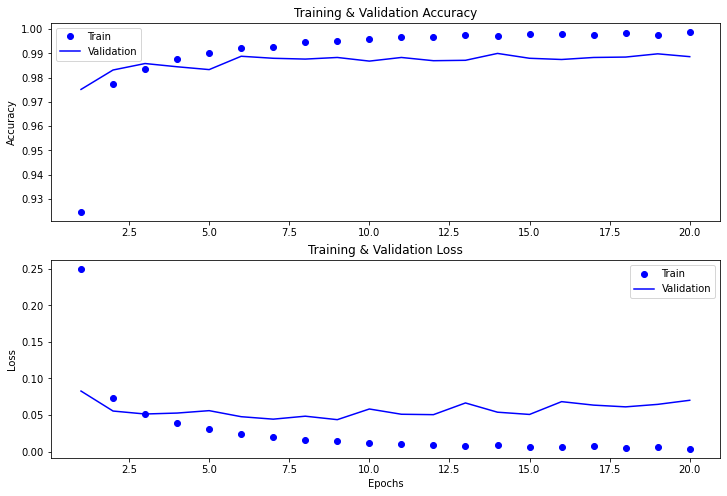

In [20]:
plot_performance(history)

# Test Accuracy

In [21]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy on Test Set : {accuracy:.4f}')

10000/10000 [==============================] - 1s 61us/sample - loss: 0.0467 - accuracy: 0.9895
Accuracy on Test Set : 0.9895


# Keract

In [22]:
k_in = X_test[:1]
k_target = y_test[:1]

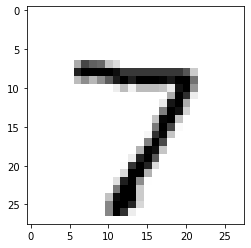

In [23]:
plt.imshow(k_in.squeeze(), cmap=plt.cm.binary)

## Layer Activations

conv2d (1, 24, 24, 6) 


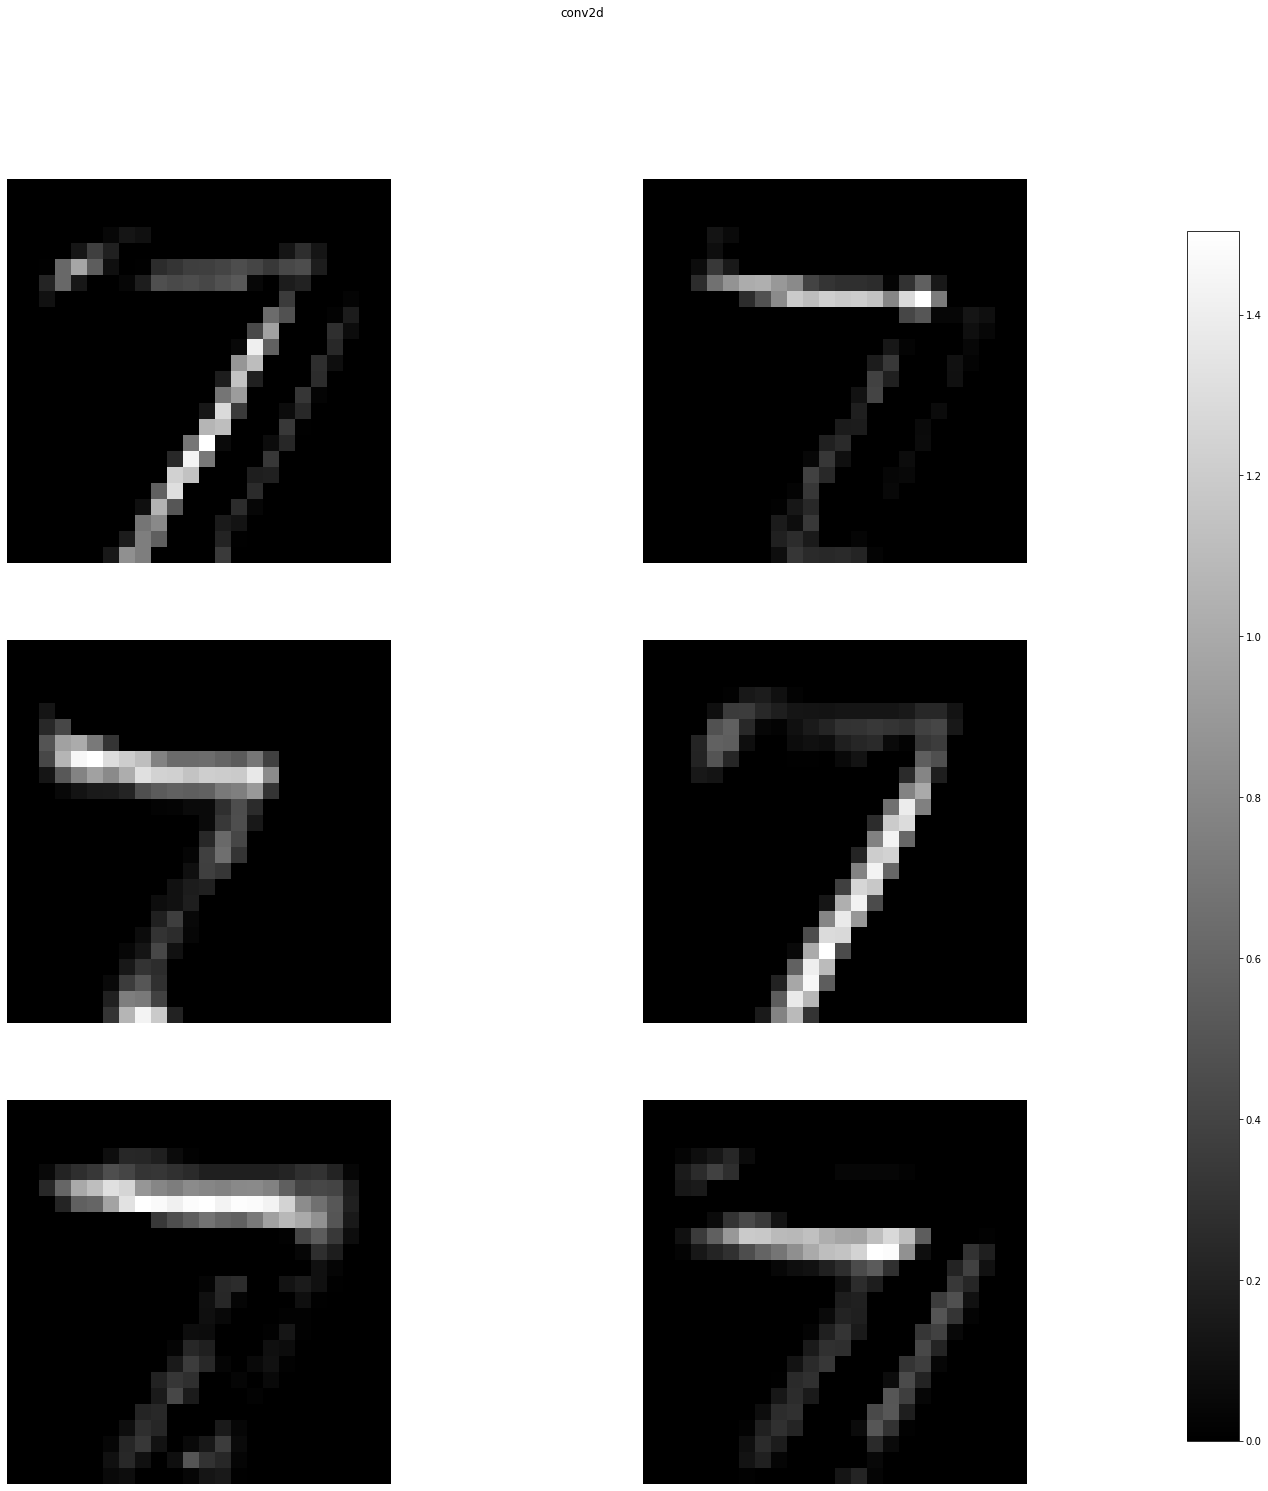

max_pooling2d (1, 12, 12, 6) 


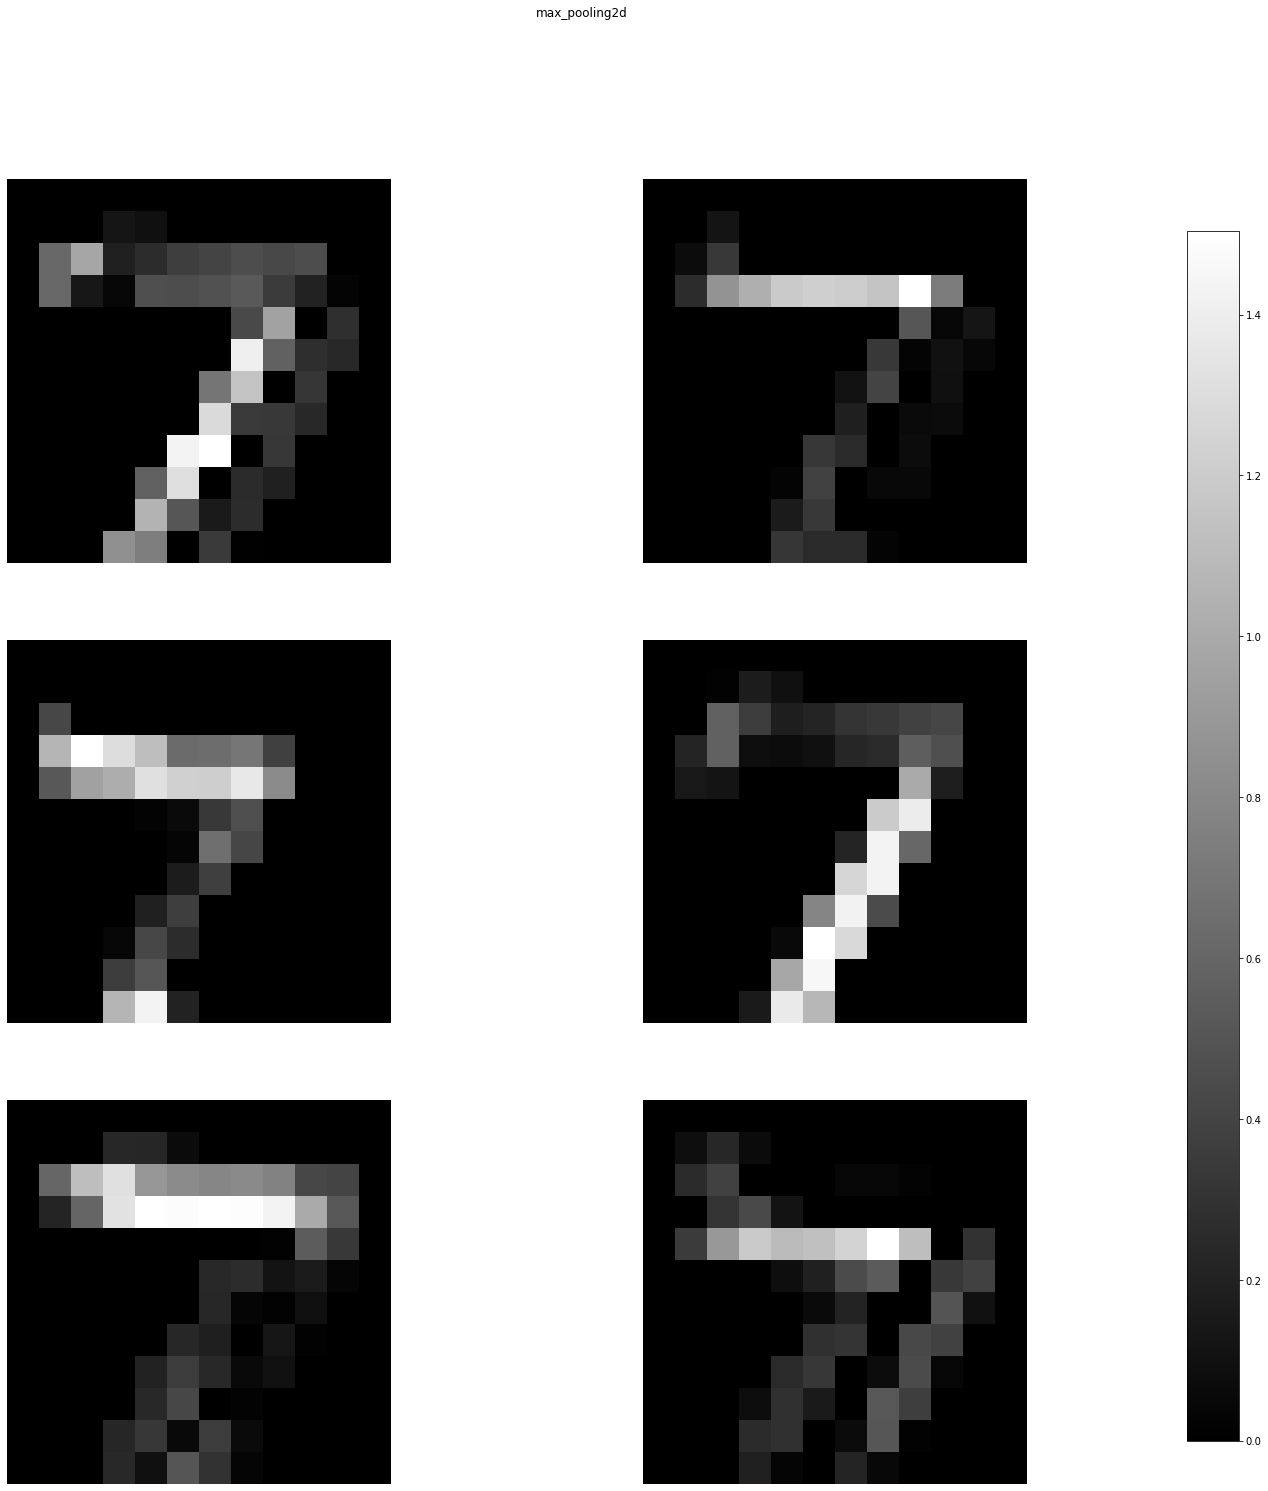

conv2d_1 (1, 8, 8, 12) 


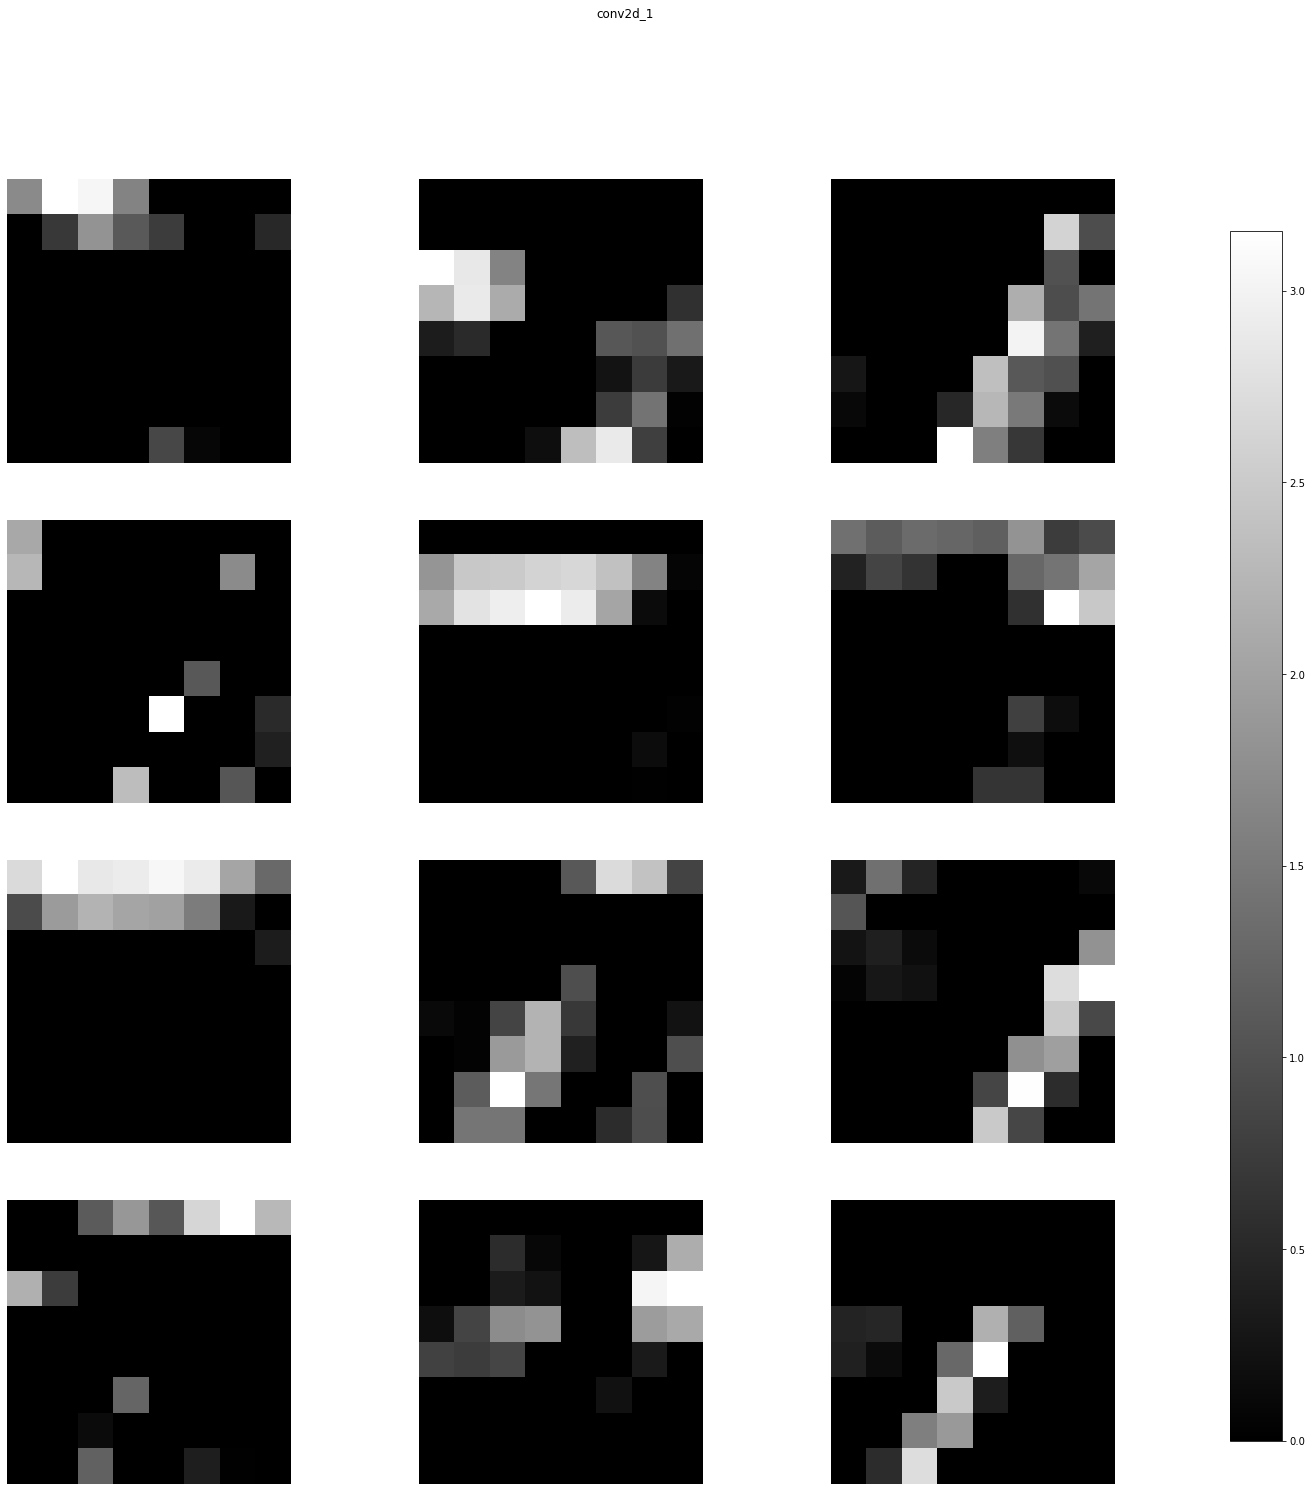

flatten (1, 768) 


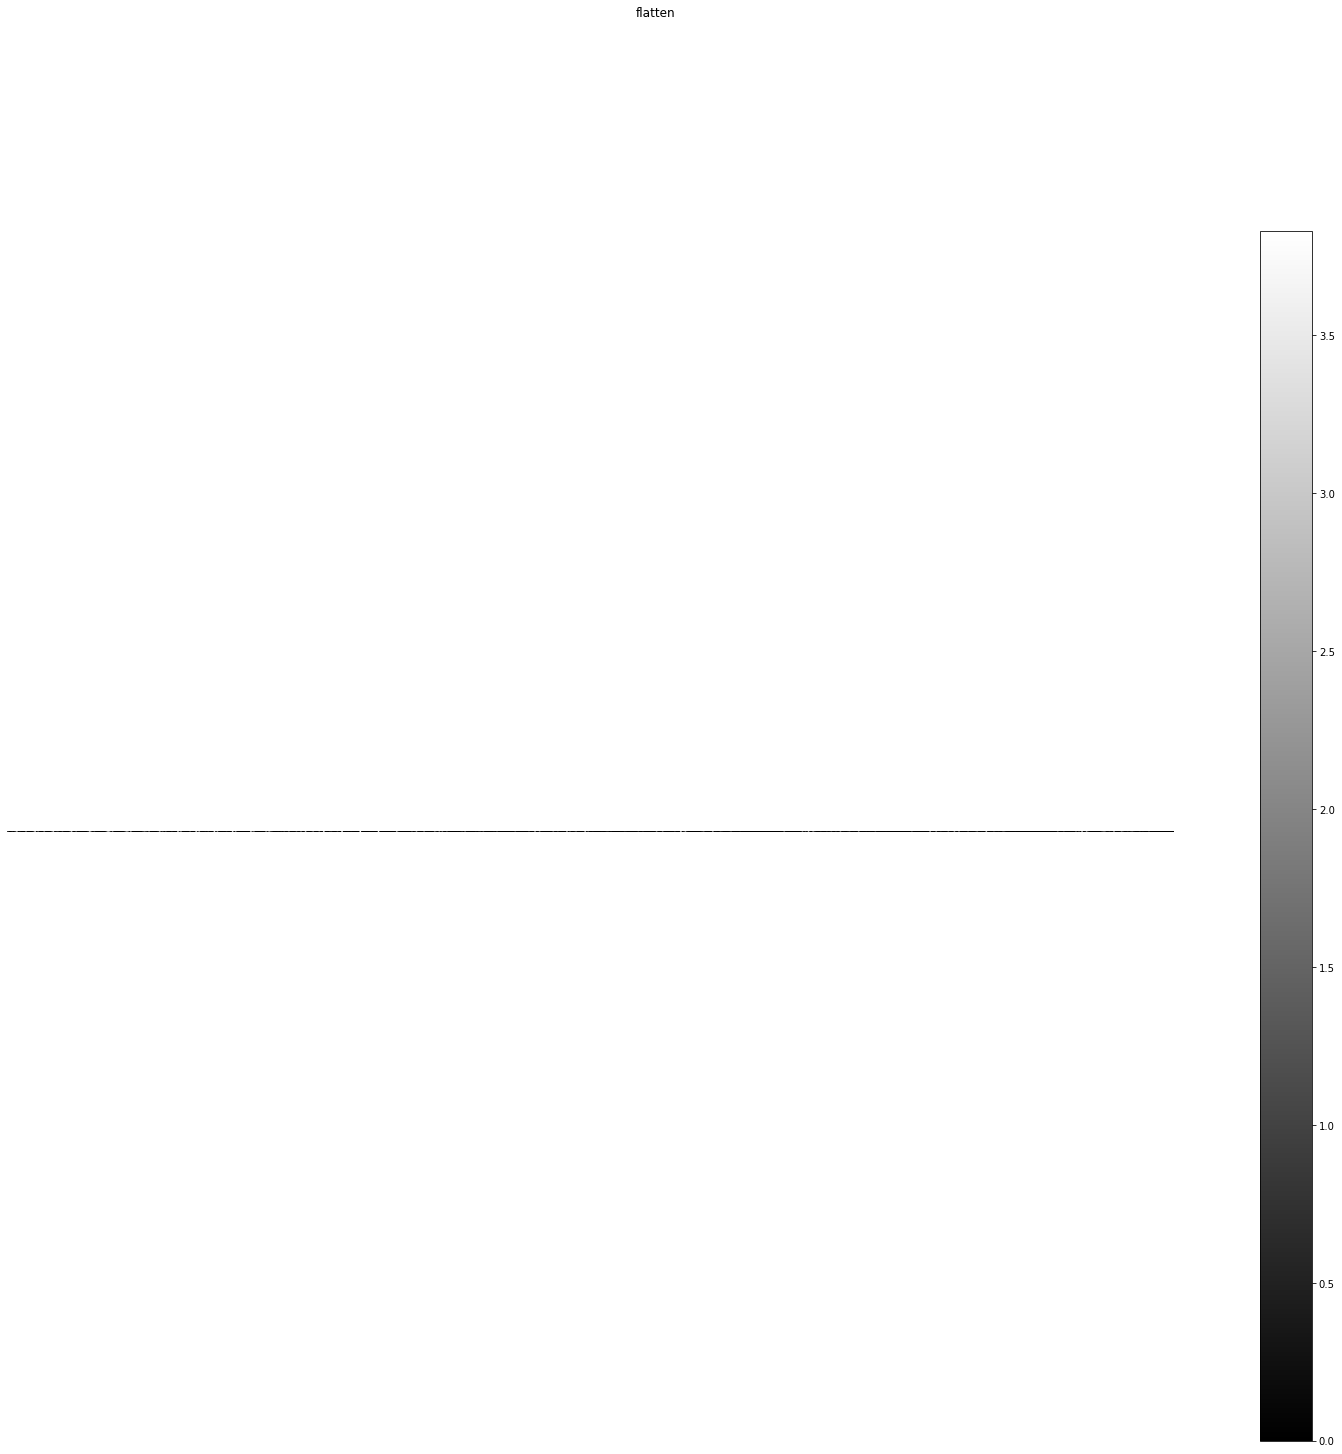

dense (1, 100) 


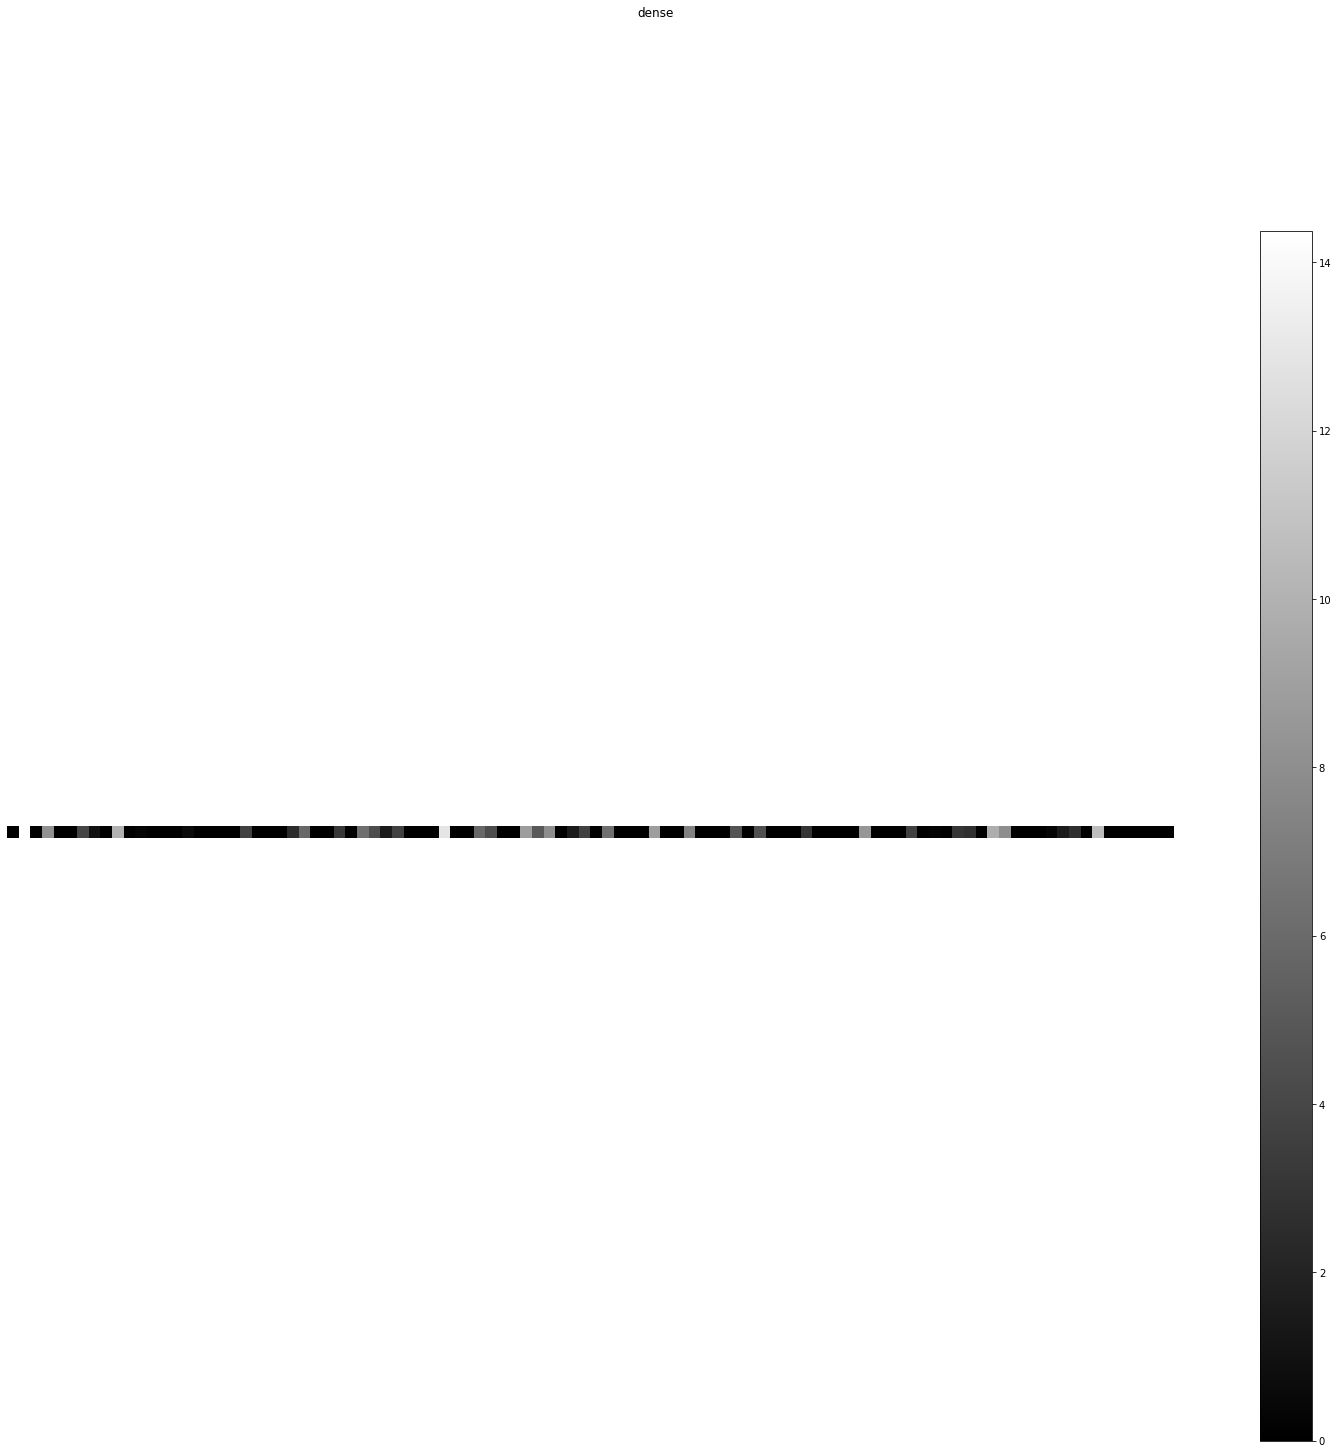

dense_1 (1, 10) 


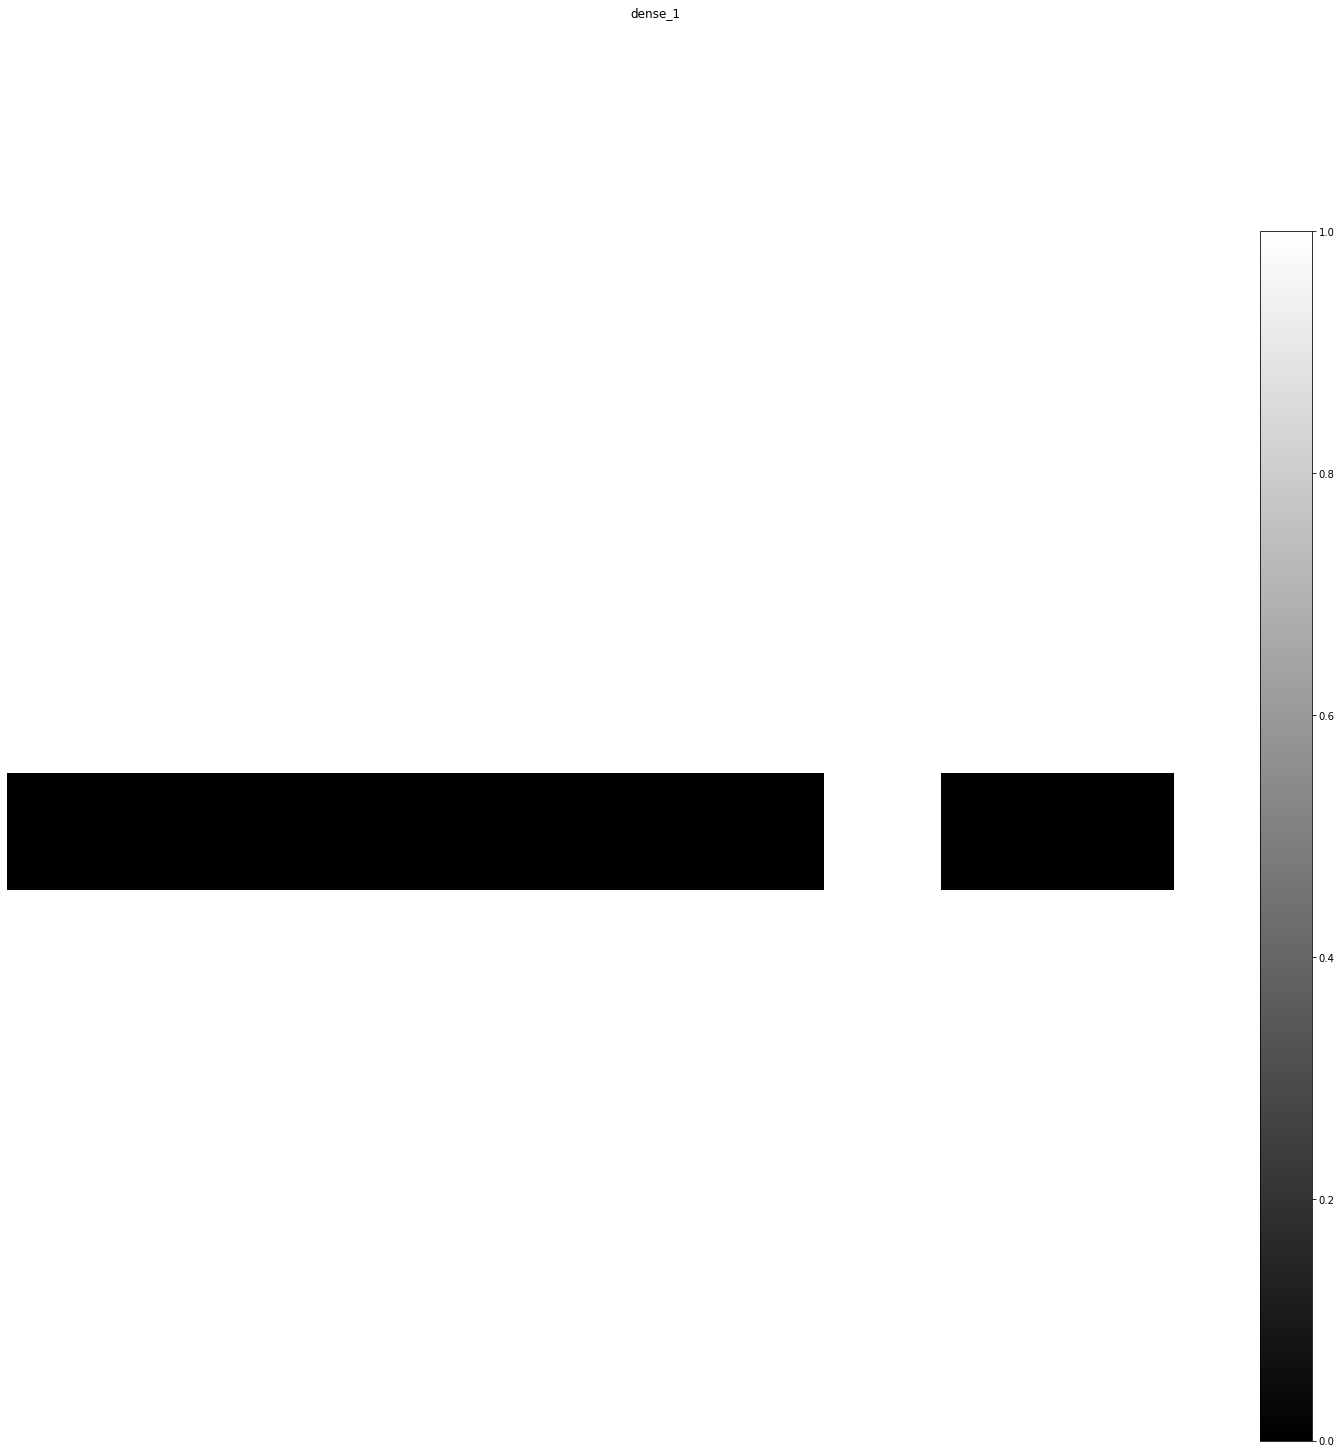

In [24]:
activations = get_activations(model, k_in)
display_activations(activations, cmap='gray', save=False)

## Convolutional Heatmaps

conv2d (1, 24, 24, 6) 


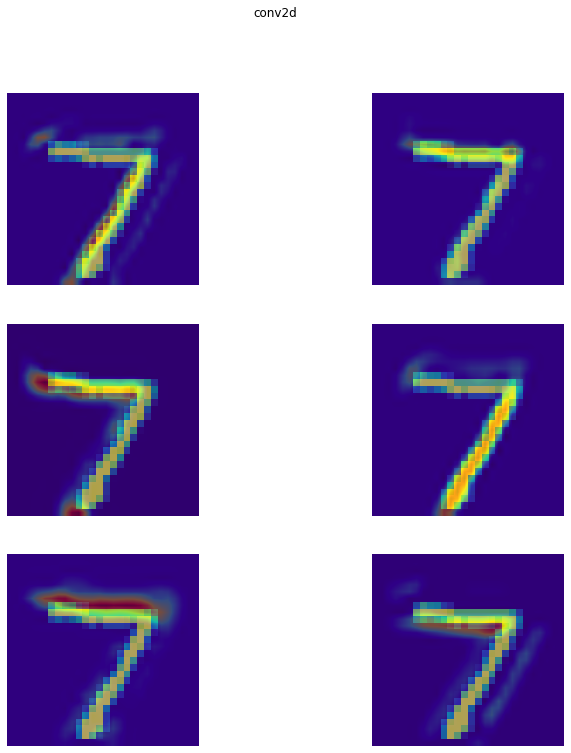

max_pooling2d (1, 12, 12, 6) 


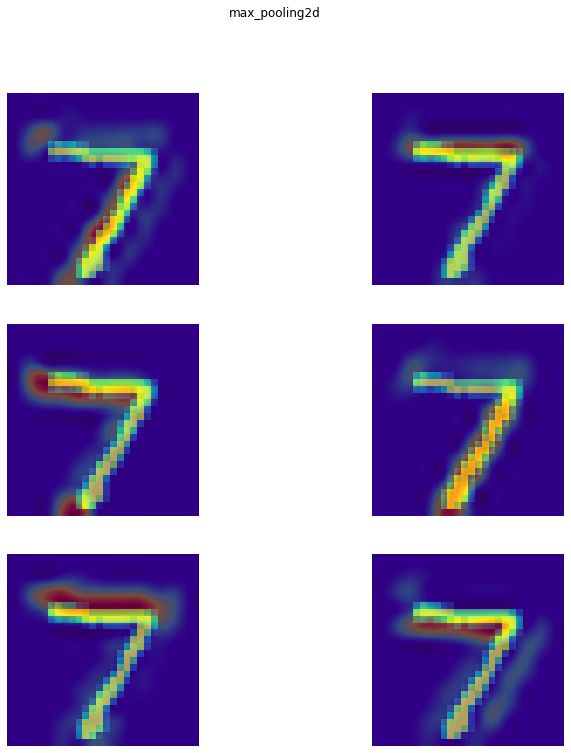

conv2d_1 (1, 8, 8, 12) 


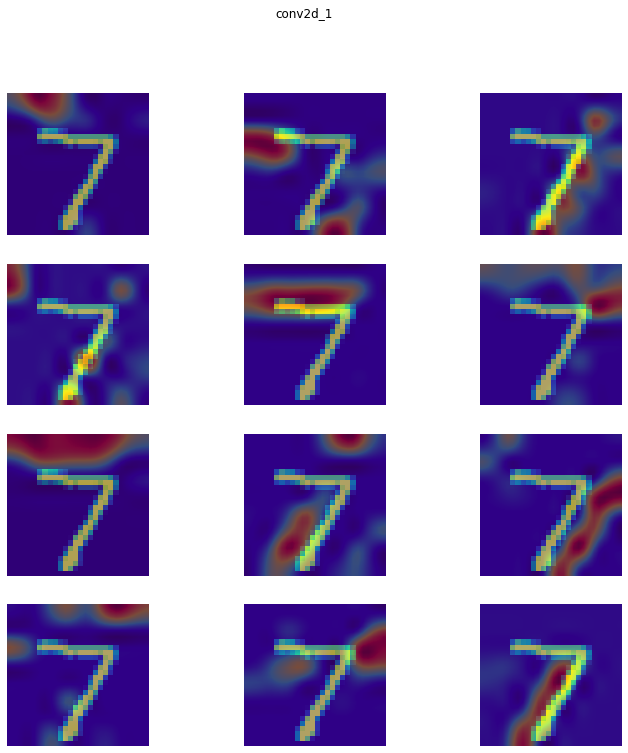

flatten (1, 768) -> Skipped. 2D Activations.
dense (1, 100) -> Skipped. 2D Activations.
dense_1 (1, 10) -> Skipped. 2D Activations.


In [25]:
display_heatmaps(activations, k_in, save=False)

# Errors

In [26]:
yhat = model.predict_classes(X_test)
yhat_proba = model.predict(X_test)

In [27]:
confusion_matrix(yhat, y_test, labels=[0,1,2,3,4,5,6,7,8,9])

array([[ 976,    0,    2,    0,    0,    0,    3,    0,    1,    0],
       [   0, 1132,    1,    0,    0,    0,    2,    0,    0,    0],
       [   1,    0, 1019,    1,    1,    1,    2,    3,    0,    0],
       [   0,    2,    0, 1003,    1,    6,    1,    3,    2,    0],
       [   0,    0,    2,    0,  964,    0,    1,    0,    0,    4],
       [   0,    0,    0,    3,    0,  880,    4,    0,    3,    3],
       [   0,    0,    0,    0,    0,    2,  944,    0,    1,    0],
       [   1,    0,    4,    0,    2,    0,    0, 1016,    0,    3],
       [   2,    0,    4,    2,    1,    0,    1,    1,  962,    0],
       [   0,    1,    0,    1,   13,    3,    0,    5,    5,  999]])

In [28]:
print(classification_report(yhat, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       982
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1028
           3       0.99      0.99      0.99      1018
           4       0.98      0.99      0.99       971
           5       0.99      0.99      0.99       893
           6       0.99      1.00      0.99       947
           7       0.99      0.99      0.99      1026
           8       0.99      0.99      0.99       973
           9       0.99      0.97      0.98      1027

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Examples

In [29]:
indexes = [i for i, val in enumerate(yhat == y_test) if not val]

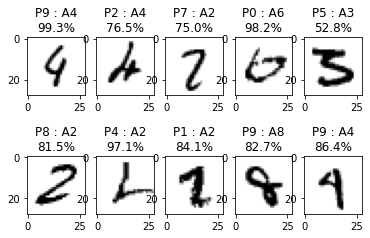

In [30]:
show = 10
counter = 1
cols = 5
rows = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for index in indexes:
    n_col = (counter - 1) % cols
    n_row = (counter - 1) // cols
    
    predicted = yhat[index]
    actual    = y_test[index]
    conf      = yhat_proba[index][predicted]
    
    title = f'P{predicted} : A{actual}\n{conf * 100.0:.1f}%'
    ax[n_row, n_col].imshow(X_test[index].reshape(28,28), cmap=plt.cm.binary)
    ax[n_row, n_col].set_title(title)
    
    counter += 1
    if counter > show:
        break
plt.show()